In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_FITNESS_ADVANTAGE": fitness_advantage,
        "MILL_REPLICATE": replicate,
    }
    for replicate in range(10)
    for fitness_advantage in [0.0, 0.1, 1.0]
]

for i, pp in enumerate(parameter_packs):
    with open(
        f"gene-selection-inference-parameterization-{i}.yaml", "w"
    ) as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_FITNESS_ADVANTAGE: float
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_FITNESS_ADVANTAGE = 0.1
MILL_REPLICATE = 5


In [5]:
import copy
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools
from hstrat import hstrat
from keyname import keyname as kn
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


# Parameters


In [7]:
HSTRAT_RESOLUTION = 1000
HSTRAT_DIFFERENTIA_WIDTH = 64

TOURNAMENT_SIZE = 2

NGEN = 200

POPULATION_SIZE = 400


# Setup


In [8]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register(
    "individual",
    lambda *args, **kwargs: deap_creator.Individual([0.0]),
    deap_creator.Individual,
    n=1,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (individual[0] + random.random(),)


toolbox.register("evaluate", evalOneMax)
# hack to ensure gene annotation remains associated with gene
toolbox.register("mate", lambda x, y: random.choice([(x, y), (y, x)]))
toolbox.register("mutate", lambda x: tuple(x))
toolbox.register("select", deap_tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Decorate the variation operators
toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [9]:
# Create the population and populate the history
population = toolbox.population(n=POPULATION_SIZE)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.nominal_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = hstrat.HereditaryStratigraphicColumn(
        stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
        stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
        initial_stratum_annotation=0,
    ).CloneDescendant(0)


# Do the evolution, the decorators will take care of updating the
# history
prevalences = []
for gen in tqdm(range(NGEN)):
    prevalences.append(sum(1 for x in population if x[0] > 0))

    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=0.0
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    population = [copy.deepcopy(ind) for ind in population]

    if gen >= NGEN // 4:
        if prevalences[-1] == 0:
            population[0][0] = MILL_FITNESS_ADVANTAGE



  0%|                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                        | 1/200 [00:01<05:16,  1.59s/it]

  1%|█▌                                                                                                                                                       | 2/200 [00:03<06:38,  2.01s/it]

  2%|██▎                                                                                                                                                      | 3/200 [00:06<06:53,  2.10s/it]

  2%|███                                                                                                                                                      | 4/200 [00:07<06:27,  1.98s/it]

  2%|███▊                                                                                                                                                     | 5/200 [00:09<05:48,  1.79s/it]

  3%|████▌                                                                                                                                                    | 6/200 [00:11<05:44,  1.78s/it]

  4%|█████▎                                                                                                                                                   | 7/200 [00:12<05:31,  1.72s/it]

  4%|██████                                                                                                                                                   | 8/200 [00:14<05:30,  1.72s/it]

  4%|██████▉                                                                                                                                                  | 9/200 [00:16<05:58,  1.88s/it]

  5%|███████▌                                                                                                                                                | 10/200 [00:18<06:02,  1.91s/it]

  6%|████████▎                                                                                                                                               | 11/200 [00:20<06:08,  1.95s/it]

  6%|█████████                                                                                                                                               | 12/200 [00:23<06:30,  2.08s/it]

  6%|█████████▉                                                                                                                                              | 13/200 [00:25<06:24,  2.06s/it]

  7%|██████████▋                                                                                                                                             | 14/200 [00:26<05:58,  1.93s/it]

  8%|███████████▍                                                                                                                                            | 15/200 [00:28<06:17,  2.04s/it]

  8%|████████████▏                                                                                                                                           | 16/200 [00:30<06:01,  1.96s/it]

  8%|████████████▉                                                                                                                                           | 17/200 [00:32<06:03,  1.99s/it]

  9%|█████████████▋                                                                                                                                          | 18/200 [00:34<06:03,  2.00s/it]

 10%|██████████████▍                                                                                                                                         | 19/200 [00:37<06:40,  2.21s/it]

 10%|███████████████▏                                                                                                                                        | 20/200 [00:39<06:26,  2.14s/it]

 10%|███████████████▉                                                                                                                                        | 21/200 [00:42<07:08,  2.39s/it]

 11%|████████████████▋                                                                                                                                       | 22/200 [00:44<07:05,  2.39s/it]

 12%|█████████████████▍                                                                                                                                      | 23/200 [00:47<07:24,  2.51s/it]

 12%|██████████████████▏                                                                                                                                     | 24/200 [00:49<07:05,  2.42s/it]

 12%|███████████████████                                                                                                                                     | 25/200 [00:52<06:56,  2.38s/it]

 13%|███████████████████▊                                                                                                                                    | 26/200 [00:54<07:11,  2.48s/it]

 14%|████████████████████▌                                                                                                                                   | 27/200 [00:57<07:26,  2.58s/it]

 14%|█████████████████████▎                                                                                                                                  | 28/200 [01:00<07:56,  2.77s/it]

 14%|██████████████████████                                                                                                                                  | 29/200 [01:04<08:41,  3.05s/it]

 15%|██████████████████████▊                                                                                                                                 | 30/200 [01:08<09:04,  3.20s/it]

 16%|███████████████████████▌                                                                                                                                | 31/200 [01:11<08:57,  3.18s/it]

 16%|████████████████████████▎                                                                                                                               | 32/200 [01:14<08:53,  3.17s/it]

 16%|█████████████████████████                                                                                                                               | 33/200 [01:17<08:23,  3.02s/it]

 17%|█████████████████████████▊                                                                                                                              | 34/200 [01:20<08:16,  2.99s/it]

 18%|██████████████████████████▌                                                                                                                             | 35/200 [01:23<08:38,  3.14s/it]

 18%|███████████████████████████▎                                                                                                                            | 36/200 [01:26<08:39,  3.17s/it]

 18%|████████████████████████████                                                                                                                            | 37/200 [01:30<08:55,  3.29s/it]

 19%|████████████████████████████▉                                                                                                                           | 38/200 [01:33<08:28,  3.14s/it]

 20%|█████████████████████████████▋                                                                                                                          | 39/200 [01:36<08:22,  3.12s/it]

 20%|██████████████████████████████▍                                                                                                                         | 40/200 [01:38<07:56,  2.98s/it]

 20%|███████████████████████████████▏                                                                                                                        | 41/200 [01:41<07:47,  2.94s/it]

 21%|███████████████████████████████▉                                                                                                                        | 42/200 [01:45<08:39,  3.29s/it]

 22%|████████████████████████████████▋                                                                                                                       | 43/200 [01:49<08:35,  3.28s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 44/200 [01:51<08:12,  3.15s/it]

 22%|██████████████████████████████████▏                                                                                                                     | 45/200 [01:55<08:43,  3.38s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 46/200 [01:58<08:25,  3.28s/it]

 24%|███████████████████████████████████▋                                                                                                                    | 47/200 [02:02<08:19,  3.26s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 48/200 [02:07<09:39,  3.81s/it]

 24%|█████████████████████████████████████▏                                                                                                                  | 49/200 [02:12<10:54,  4.33s/it]

 25%|██████████████████████████████████████                                                                                                                  | 50/200 [02:16<10:23,  4.15s/it]

 26%|██████████████████████████████████████▊                                                                                                                 | 51/200 [02:20<10:03,  4.05s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 52/200 [02:23<09:09,  3.71s/it]

 26%|████████████████████████████████████████▎                                                                                                               | 53/200 [02:27<09:13,  3.77s/it]

 27%|█████████████████████████████████████████                                                                                                               | 54/200 [02:30<08:38,  3.55s/it]

 28%|█████████████████████████████████████████▊                                                                                                              | 55/200 [02:33<08:27,  3.50s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 56/200 [02:38<09:10,  3.82s/it]

 28%|███████████████████████████████████████████▎                                                                                                            | 57/200 [02:42<09:42,  4.07s/it]

 29%|████████████████████████████████████████████                                                                                                            | 58/200 [02:46<09:09,  3.87s/it]

 30%|████████████████████████████████████████████▊                                                                                                           | 59/200 [02:49<08:37,  3.67s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 60/200 [02:52<08:24,  3.61s/it]

 30%|██████████████████████████████████████████████▎                                                                                                         | 61/200 [02:57<08:49,  3.81s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 62/200 [03:01<08:58,  3.90s/it]

 32%|███████████████████████████████████████████████▉                                                                                                        | 63/200 [03:05<09:28,  4.15s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 64/200 [03:10<09:36,  4.24s/it]

 32%|█████████████████████████████████████████████████▍                                                                                                      | 65/200 [03:14<09:34,  4.26s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 66/200 [03:19<09:34,  4.28s/it]

 34%|██████████████████████████████████████████████████▉                                                                                                     | 67/200 [03:22<09:15,  4.18s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 68/200 [03:27<09:26,  4.29s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                   | 69/200 [03:31<09:20,  4.28s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 70/200 [03:37<09:58,  4.60s/it]

 36%|█████████████████████████████████████████████████████▉                                                                                                  | 71/200 [03:41<09:27,  4.40s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 72/200 [03:44<09:00,  4.22s/it]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 73/200 [03:49<09:21,  4.42s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 74/200 [03:55<10:21,  4.93s/it]

 38%|█████████████████████████████████████████████████████████                                                                                               | 75/200 [04:00<10:16,  4.93s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 76/200 [04:06<10:23,  5.03s/it]

 38%|██████████████████████████████████████████████████████████▌                                                                                             | 77/200 [04:10<10:10,  4.97s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 78/200 [04:16<10:47,  5.31s/it]

 40%|████████████████████████████████████████████████████████████                                                                                            | 79/200 [04:22<10:59,  5.45s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 80/200 [04:28<11:15,  5.63s/it]

 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 81/200 [04:33<10:53,  5.49s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 82/200 [04:37<09:46,  4.97s/it]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 83/200 [04:43<10:05,  5.17s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 84/200 [04:47<09:29,  4.91s/it]

 42%|████████████████████████████████████████████████████████████████▌                                                                                       | 85/200 [04:52<09:31,  4.97s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 86/200 [04:58<09:41,  5.10s/it]

 44%|██████████████████████████████████████████████████████████████████                                                                                      | 87/200 [05:02<09:16,  4.93s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 88/200 [05:08<09:27,  5.06s/it]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 89/200 [05:12<09:08,  4.94s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 90/200 [05:17<08:48,  4.81s/it]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 91/200 [05:21<08:37,  4.75s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 92/200 [05:26<08:34,  4.76s/it]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 93/200 [05:32<09:04,  5.08s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 94/200 [05:38<09:19,  5.28s/it]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 95/200 [05:43<08:58,  5.13s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 96/200 [05:48<08:50,  5.10s/it]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 97/200 [05:53<08:54,  5.19s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 98/200 [05:58<08:40,  5.10s/it]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 99/200 [06:03<08:25,  5.00s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 100/200 [06:08<08:30,  5.10s/it]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 101/200 [06:14<08:51,  5.37s/it]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 102/200 [06:20<08:55,  5.46s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 103/200 [06:26<09:07,  5.64s/it]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 104/200 [06:31<08:55,  5.58s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/200 [06:37<08:53,  5.61s/it]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 106/200 [06:42<08:30,  5.43s/it]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 107/200 [06:47<08:13,  5.30s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 108/200 [06:53<08:39,  5.64s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 109/200 [06:58<08:11,  5.40s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 110/200 [07:03<07:58,  5.32s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 111/200 [07:08<07:34,  5.10s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 112/200 [07:14<08:02,  5.48s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 113/200 [07:20<08:00,  5.52s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 114/200 [07:25<07:52,  5.50s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 115/200 [07:31<08:03,  5.69s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 116/200 [07:37<08:08,  5.81s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 117/200 [07:44<08:09,  5.90s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 118/200 [07:49<07:49,  5.73s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 119/200 [07:55<07:46,  5.76s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 120/200 [08:01<08:03,  6.05s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 121/200 [08:07<07:56,  6.03s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 122/200 [08:13<07:40,  5.90s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 123/200 [08:20<08:10,  6.36s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 124/200 [08:27<08:17,  6.55s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 125/200 [08:34<08:03,  6.45s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 126/200 [08:40<07:49,  6.35s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 127/200 [08:46<07:48,  6.42s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 128/200 [08:53<07:50,  6.54s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 129/200 [09:00<07:56,  6.71s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 130/200 [09:07<07:56,  6.80s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 131/200 [09:14<07:46,  6.77s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 132/200 [09:20<07:32,  6.65s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 133/200 [09:27<07:25,  6.64s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 134/200 [09:34<07:21,  6.70s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 135/200 [09:40<06:59,  6.45s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 136/200 [09:46<06:59,  6.55s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 137/200 [09:53<06:48,  6.48s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 138/200 [09:59<06:43,  6.51s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 139/200 [10:07<06:50,  6.73s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 140/200 [10:13<06:46,  6.77s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 141/200 [10:20<06:40,  6.79s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 142/200 [10:27<06:31,  6.75s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 143/200 [10:34<06:27,  6.79s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 144/200 [10:41<06:27,  6.92s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 145/200 [10:47<06:09,  6.72s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 146/200 [10:54<06:05,  6.77s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/200 [11:01<06:01,  6.82s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/200 [11:10<06:21,  7.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 149/200 [11:19<06:38,  7.82s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 150/200 [11:25<06:15,  7.52s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 151/200 [11:32<05:54,  7.23s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 152/200 [11:39<05:49,  7.28s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 153/200 [11:46<05:34,  7.13s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 154/200 [11:53<05:22,  7.01s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 155/200 [12:00<05:14,  7.00s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 156/200 [12:07<05:11,  7.08s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 157/200 [12:15<05:13,  7.30s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/200 [12:22<05:03,  7.23s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 159/200 [12:29<04:52,  7.14s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 160/200 [12:36<04:42,  7.05s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 161/200 [12:44<04:49,  7.42s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 162/200 [12:53<04:57,  7.82s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 163/200 [13:01<04:54,  7.97s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 164/200 [13:09<04:48,  8.01s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 165/200 [13:17<04:34,  7.83s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 166/200 [13:24<04:16,  7.54s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 167/200 [13:32<04:16,  7.76s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 168/200 [13:38<03:53,  7.31s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 169/200 [13:45<03:47,  7.33s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 170/200 [13:54<03:47,  7.58s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 171/200 [14:01<03:41,  7.64s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 172/200 [14:09<03:35,  7.71s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 173/200 [14:18<03:34,  7.94s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 174/200 [14:27<03:32,  8.19s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 175/200 [14:35<03:28,  8.35s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 176/200 [14:43<03:14,  8.12s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 177/200 [14:51<03:08,  8.20s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 178/200 [15:00<03:02,  8.29s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 179/200 [15:08<02:55,  8.37s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 180/200 [15:17<02:50,  8.52s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 181/200 [15:25<02:38,  8.33s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 182/200 [15:33<02:30,  8.37s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 183/200 [15:42<02:21,  8.32s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 184/200 [15:50<02:10,  8.18s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 185/200 [15:58<02:03,  8.24s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 186/200 [16:07<01:57,  8.42s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 187/200 [16:15<01:50,  8.51s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 188/200 [16:24<01:42,  8.54s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 189/200 [16:33<01:35,  8.70s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 190/200 [16:42<01:27,  8.79s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 191/200 [16:51<01:18,  8.72s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 192/200 [16:59<01:09,  8.63s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 193/200 [17:08<01:00,  8.60s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 194/200 [17:17<00:52,  8.75s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 195/200 [17:26<00:44,  8.96s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196/200 [17:36<00:36,  9.14s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 197/200 [17:45<00:27,  9.06s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [17:54<00:18,  9.16s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [18:04<00:09,  9.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:14<00:00,  9.57s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:14<00:00,  5.47s/it]

# Visualization


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=5+viz=plot-sweep-and-annotations+ext=.pdf


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=5+viz=plot-sweep-and-annotations+ext=.png


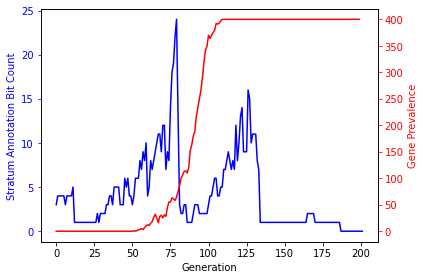

In [10]:
annotations = [
    s.GetAnnotation().bit_count()
    for s in population[0].gene_annotation.IterRetainedStrata()
]


def plot_sweep_and_annotations():
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots()

    # Make the first plot on ax1
    sns.lineplot(data=annotations, color="b", ax=ax1)
    ax1.set_ylabel("Stratum Annotation Bit Count", color="b")
    ax1.tick_params("y", colors="b")

    # Create a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Make the second plot on ax2
    sns.lineplot(data=prevalences, color="r", ax=ax2)
    ax2.set_ylabel("Gene Prevalence", color="r")
    ax2.tick_params("y", colors="r")

    ax1.set_xlabel("Generation")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


tp.tee(
    plot_sweep_and_annotations,
    teeplot_outattrs={
        "notebook": "gene-selection-inference",
        "replicate": str(MILL_REPLICATE),
        "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
    },
)


In [11]:
records = [
    {
        "notebook": "gene-selection-inference",
        "replicate": MILL_REPLICATE,
        "fitness-advantage": MILL_FITNESS_ADVANTAGE,
        "generation": generation,
        "prevalence": prevalence,
        "annotation": annotation,
    }
    for generation, (prevalence, annotation) in enumerate(
        zip(prevalences, annotations)
    )
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "prevalence-annotation-by-generation",
            "notebook": "gene-selection-inference",
            "replicate": str(MILL_REPLICATE),
            "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
            "ext": ".csv",
        }
    )
)
